In [2]:
% matplotlib inline
from __future__ import print_function, division
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def read_file(path):
    t0 = time.time()
    df = pd.read_csv(path, na_values=['null', 'Na'])
    print("%.2f secs ==> pd.read_csv"%(time.time()-t0))
    df['useragent_1'] = df['useragent'].apply(lambda x: x.split('_')[0])
    df['useragent_2'] = df['useragent'].apply(lambda x: x.split('_')[1])
    return df

In [4]:
df_train = read_file('./data/train.csv')
df_val = read_file('./data/validation.csv')
df_test = read_file('./data/test.csv')
df_train.head()

18.22 secs ==> pd.read_csv
2.21 secs ==> pd.read_csv
1.94 secs ==> pd.read_csv


,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,useragent_1,useragent_2
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,...,0.0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN,windows,ie
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,...,NaN,0,10722,294,23,NaN,2821,NaN,windows,chrome
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,...,0.0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110",windows,ie
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,...,1.0,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111",windows,ie
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,...,NaN,133,7330,277,133,NaN,2259,NaN,windows,ie


## Feature Engineering

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, mean_squared_error

In [6]:
col_names=df_train.columns.tolist()
print(col_names)

['click', 'weekday', 'hour', 'bidid', 'userid', 'useragent', 'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag', 'useragent_1', 'useragent_2']


In [7]:
print (df_train.describe())

              click       weekday          hour        region          city  \
count  2.430981e+06  2.430981e+06  2.430981e+06  2.430981e+06  2.430981e+06   
mean   7.375623e-04  2.888556e+00  1.348925e+01  1.493833e+02  1.543295e+02   
std    2.714809e-02  2.055223e+00  6.567105e+00  1.020631e+02  1.033093e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  1.000000e+00  1.000000e+01  7.900000e+01  7.900000e+01   
50%    0.000000e+00  3.000000e+00  1.400000e+01  1.460000e+02  1.520000e+02   
75%    0.000000e+00  5.000000e+00  1.900000e+01  2.160000e+02  2.220000e+02   
max    1.000000e+00  6.000000e+00  2.300000e+01  3.950000e+02  3.990000e+02   

         adexchange  urlid     slotwidth    slotheight    slotformat  \
count  2.381152e+06    0.0  2.430981e+06  2.430981e+06  1.925991e+06   
mean   2.109685e+00    NaN  5.774218e+02  1.885723e+02  3.335576e-01   
std    8.764370e-01    NaN  3.216738e+02  1.314946e+02  5.887512e-01   


In [8]:
def to_index(df, feature):
    return LabelEncoder().fit_transform(df[feature].values)

def to_one_hot(df, features):
    return OneHotEncoder().fit_transform(df[features].values).toarray()

def bid_price(bidprice):
    if bidprice <= 241:
        return 0
    if 241< bidprice <= 294:
        return 1
    if 294 < bidprice <= 300:
        return 2
    if 300 < bidpreice :
        return 3
    
def pay_price(payprice):
    if payprice <= 33:
        return 0
    if 33< payprice <= 68:
        return 1
    if 68 < payprice <= 99:
        return 2
    if 99 < payprice :
        return 3    
    
def hour_fn(hour):
    if hour <= 6:
        return 0
    if 6 < hour <= 12:
        return 1
    if 12 < hour <= 18:
        return 2
    if 18 < hour <= 24:
        return 3

def slot_width_fn(width):
    if width <= 300:
        return 0
    if 300 < width <= 728:
        return 1
    if width > 728:
        return 2

def slot_height_fn(height):
    if height <= 100:
        return 0
    if 100 < height <= 240:
        return 1
    if height > 240:
        return 2

    
def city_fn(city):
    if city <= 93:
        return 0
    if 93 < city <= 187:
        return 1
    if 187 < city <= 303:
        return 2
    if city > 303:
        return 3

def region_fn(region):
    if region <= 65:
        return 0
    if 65 < region <= 183:
        return 1
    if 183 < region <= 325:
        return 2
    if region > 325:
        return 3
    
def slot_price_fn(price):
    if price <= 50:
        return 0
    if 50 < price <= 98:
        return 1
    if price > 98:
        return 2
    
def preprocess(df):
    df['bidprice'] = df['bidprice'].apply(bid_price)
    df['payprice'] = df['payprice'].apply(pay_price)
    df['hour'] = df['hour'].apply(hour_fn)
    df['slotwidth'] = df['slotwidth'].apply(slot_width_fn)
    df['slotheight'] = df['slotheight'].apply(slot_height_fn)
    df['city'] = df['city'].apply(city_fn)
    df['region'] = df['region'].apply(region_fn)
    df['slotvisibility'] = df['slotvisibility'].apply(lambda x: str(x))
    df['slotformat'] = df['slotformat'].apply(lambda x: str(x))
    df['adexchange'] = df['adexchange'].apply(lambda x: str(x))
    df['domain'] = df['domain'].apply(lambda x: str(x))
    df['slotprice'] = df['slotprice'].apply(slot_price_fn)
    
    for feat in ['useragent_1', 'useragent_2', 'advertiser', 'slotvisibility', 'slotformat', 'adexchange',
                 'bidid','userid','slotid','domain']:
        df[feat] = to_index(df, feat)
    c=['weekday', 'hour', 'useragent_1', 'useragent_2','city', 'region',
         'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
         'advertiser','bidid','userid','slotid','bidprice','payprice']
    one_hot =df[c]
    return one_hot


### Choose features

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


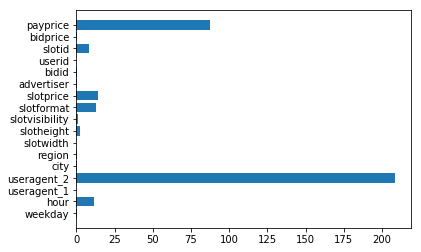

In [14]:
ratio = 100
pos_df = df_train[df_train['click']==1]
neg_df = df_train[df_train['click']==0]
reduced_neg_df = neg_df.sample(100*len(pos_df), random_state=100)
down_sample_df = pd.concat([pos_df]+[reduced_neg_df], ignore_index=True)

x_train = preprocess(down_sample_df.copy())
y_train = down_sample_df['click'].values

import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(x_train, y_train)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?

plt.barh(range(len(x_train.columns)), scores)
plt.yticks(range(len(x_train.columns)), x_train.columns)
plt.show()
